In [57]:
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

In [58]:
df = pd.read_csv('train_data.csv')
df

,Sentence,Emotion
0,کی گفته مرد گریه نمیکنه!؟!؟ سیلم امشب سیل #اصفهان,SAD
1,عکسی که چند روز پیش گذاشته بودم این فیلم الانش...,OTHER
2,تنهاییم شبیه تنهاییه ظهرای بچگیم شده وقتی که ه...,SAD
3,خوبه تمام قسمت‌های گوشی رو محافظت می‌کنه,HAPPY
4,این خاک مال مردمان است نه حاکمان #ایران #مهسا_...,ANGRY
...,...,...
4919,من از بو و ماندگاریش راضی بودم ، قیمتش هم‌ مناسبه,HAPPY
4920,گاز نداریم آب نداریم برق نداریم نت نداریم پول ...,SAD
4921,یکی بهم گفت برنو چرا عاشق نمیشی گفتم ما پول عا...,SAD
4922,زیادی داریم به قضیه ی گاز میپردازیم فقط فراخوا...,OTHER


In [59]:
df.shape

(4924, 2)

In [60]:
df.describe()

,Sentence,Emotion
count,4924,4924
unique,4922,5
top,#NAME?,HAPPY
freq,3,1462


In [61]:
df.isnull().sum()

Sentence    0
Emotion     0
dtype: int64

In [62]:
df.duplicated().sum()

1

<AxesSubplot: >

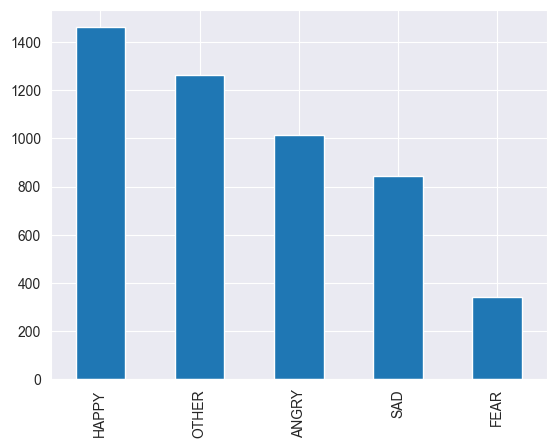

In [63]:
plot_df = df.Emotion.value_counts()
plot_df.plot(kind="bar")

# Preprocessing

At first we need to check the variety of the characters that is used in our data.

In [64]:
uniqueChars = set(''.join(df['Sentence']))
print(len(uniqueChars))
print(uniqueChars)

210
{'ی', 'ق', '»', '+', 'a', '۲', 'ث', '•', '…', '~', 'ً', 'K', '✋', 'q', 'ا', 'N', '⃟', 'َ', 'x', 'T', '&', '☝', 'C', ')', '’', 'ف', 'ᴛ', ';', '❄', '۱', '7', '۵', 'ل', '⁉', '✌', 'J', 'ە', '٫', '⛓', '؟', '\u200d', '_', 'ه', 'o', 'غ', '*', 'ة', 'ن', '“', '️', '=', 'D', '۸', 'G', 'ع', 'I', 's', '\u2067', '♥', ' ', 'r', 'ِ', 'Q', '⭕', 'ٔ', '☹', 'ص', 'ج', '%', 'w', 'n', 'ژ', 'ت', '|', '«', 'ᴏ', 'U', '☄', 'M', 'پ', 'ي', '”', 'گ', '۳', 'A', '‘', '۴', 'خ', '(', '8', 't', 'l', ']', 'L', '⊰', '[', '?', '4', 'آ', 'ذ', '٣', 'e', 'ْ', 'د', '٢', '⚽', 'S', '♂', 'ᴇ', 'W', 'R', 'ى', 'و', ',', 'g', '‐', '\n', 'ھ', 'u', '/', 'ض', '6', '\u2069', '۔', 'j', 'E', 'ہ', '.', 'y', 'ب', 'ط', 'b', '¹', '3', 'm', '۰', 'P', '١', 'ʏ', 'چ', 'O', 'ش', 'c', 'س', 'd', '،', '2', '0', '9', '°', 'م', '-', '✨', 'ر', 'H', 'B', '٬', 'ۀ', '!', '⚘', 'z', 'ء', '٦', '⭐', 'ح', 'ؤ', '✍', '٪', 'Z', '#', '\u200c', '}', 'F', '٠', '^', 'V', '☺', 'ُ', 'ک', 'أ', 'ظ', 'k', '۶', 'f', 'ّ', 'Y', '؛', 'ئ', 'ك', '5', 'p', 'ے', '\u2066', '☘',

As we can see there is three important problem.
1. There is five type of 'ی' that can be a real problem because there is a unique unicode for each one.
2. There are persian and latin numbers together that can be a problem.
3. There are capital and small letter together.

So we have to handle these problem to clean our data and make that more usable and reliable.

In here we will define two function:
1. __normalize_persian__: This function will replace persian numbers with latin and handle five kind of 'ی' and make them one.
2. __preprocess_text__: This function will apply normalize_persian on our data and also make all of our latin letters lower case.

In [65]:
def normalize_persian(text):
    # Define a function to normalize Persian characters and numbers
    persian_digits = '۰۱۲۳۴۵۶۷۸۹٦'
    english_digits = '01234567896'
    yeh_characters = ['ی', 'ي', 'ے', 'ئ', 'ى']

    text = text.translate(str.maketrans(persian_digits, english_digits))
    for char in yeh_characters:
        text = text.replace(char, 'ی')

    return text

In [66]:
def preprocess_text(text):
    # Normalize Persian characters
    text = normalize_persian(text)

    # Convert to lowercase
    text = text.lower()

    # Add more preprocessing steps as needed

    return text

In [67]:
df['Sentence'] = df['Sentence'].apply(preprocess_text)
uniqueChars = set(''.join(df['Sentence']))
print(len(uniqueChars))
print(uniqueChars)

170
{'ی', 'ق', '»', '+', 'a', 'ث', '•', '…', '~', 'ً', '✋', 'q', 'ا', '⃟', 'َ', 'x', '&', '☝', ')', '’', 'ف', 'ᴛ', ';', '❄', '7', 'ل', '⁉', '✌', 'ە', '٫', '⛓', '؟', '\u200d', '_', 'ه', 'o', 'غ', '*', 'ة', 'ن', '“', '️', '=', 'ع', 's', '\u2067', '♥', ' ', 'r', 'ِ', '⭕', 'ٔ', '☹', 'ص', 'ج', '%', 'w', 'n', 'ژ', 'ت', '|', '«', 'ᴏ', '☄', 'پ', '”', 'گ', '‘', 'خ', '(', '8', 't', 'l', ']', '⊰', '[', '?', '4', 'آ', 'ذ', '٣', 'e', 'ْ', 'د', '٢', '⚽', 'ᴇ', '♂', 'و', ',', 'g', '‐', '\n', 'ھ', 'u', '/', 'ض', '6', '\u2069', '۔', 'j', 'ہ', '.', 'y', 'ب', 'ط', 'b', '3', 'm', '١', 'ʏ', 'چ', 'ش', 'c', 'س', 'd', '،', '2', '0', '9', '°', 'م', '-', '✨', 'ر', '٬', 'ۀ', '!', '⚘', 'z', 'ء', '⭐', 'ح', 'ؤ', '✍', '٪', '#', '\u200c', '}', '٠', '^', '☺', 'ُ', 'ک', 'أ', 'ظ', 'f', 'k', 'ّ', '؛', 'ك', '5', 'p', '\u2066', '☘', 'ټ', 'ɴ', '✅', '²', ':', 'ـ', 'v', '♀', '❤', 'h', 'i', '☠', '¹', '1', 'ز'}


In [68]:
import hazm
def text_normalizer(data):
    normalizer = hazm.Normalizer()
    data['Sentence'] = data['Sentence'].apply(normalizer.normalize)
    return data

def word_tokenizer(data):
    data['Sentence'] = data['Sentence'].apply(hazm.word_tokenize)
    return data

def text_lemmatizer(data):
    lemmatizer = hazm.Lemmatizer()
    data['Sentence'] = data['Sentence'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))
    return data

In [69]:
df = text_normalizer(df)
df = word_tokenizer(df)
df = text_lemmatizer(df)
df.head()

,Sentence,Emotion
0,کی گفته مرد گریه نمیکنه !؟!؟ سیل امشب سیل #اصفهان,SAD
1,عکس که چند روز پیش گذاشت#گذار این فیلم الانشه ...,OTHER
2,تن شبیه تنهاییه ظهرای بچگیم شده وقتی‌که همه می...,SAD
3,خوبه تمام قسمت گوشید#گوش رو محافظت می‌کنه,HAPPY
4,این خاک‌مال مردمان است نه حاکمان #ایران #مهسا_...,ANGRY


In [70]:
uniqueChars = set(''.join(df['Sentence']))
print(len(uniqueChars))
print(uniqueChars)

148
{'ی', 'ق', '»', '+', 'a', '۲', 'ث', '•', '…', '~', '✋', 'q', 'ا', '⃟', 'x', '&', '☝', ')', '’', 'ف', 'ᴛ', ';', '❄', '۱', '۵', 'ل', '⁉', '✌', '٫', '⛓', '؟', '\u200d', '_', 'ه', 'o', 'غ', '*', 'ة', 'ن', '️', '=', '۸', 'ع', 's', '\u2067', '♥', ' ', 'r', '⭕', '☹', 'ص', 'ج', 'w', 'n', 'ژ', 'ت', '|', '«', 'ᴏ', '☄', 'پ', 'گ', '۳', '‘', '۴', 'خ', '(', 't', 'l', ']', '⊰', '[', '?', 'آ', 'ذ', 'e', 'د', '⚽', 'ᴇ', '♂', 'و', ',', 'g', '‐', 'u', '/', 'ض', '\u2069', 'j', '.', 'y', 'ب', 'ط', 'b', '¹', 'm', '۰', 'ʏ', 'چ', 'ش', 'c', 'س', 'd', '،', '°', 'م', '-', '✨', 'ر', '"', '٬', '!', '⚘', 'z', 'ء', '⭐', 'ح', 'ؤ', '✍', '٪', '#', '\u200c', '}', '^', '☺', 'ک', 'أ', 'ظ', 'f', '۶', 'k', '؛', 'p', '\u2066', '☘', 'ɴ', '✅', '²', ':', '۹', 'v', '♀', '❤', 'h', 'i', '☠', '۷', 'ز'}


The next step in the preprocessing was to normalize the text using the Hazm library. Normalizing text in the context of natural language processing (NLP) refers to the process of transforming text into a standardized format or representation. This typically involves tasks such as converting all text to lowercase, removing stop words (common words that do not carry significant meaning), and other similar operations. After normalizing the text, we used a word tokenizer to separate the words into individual tokens. This is an important step for many NLP tasks, as it allows us to work with the text at the word level. The next step was lemmatization, which uses linguistic knowledge to convert words to their base or dictionary form. This helps to reduce the dimensionality of the text and can improve the performance of various NLP models. All above parts was doing these important steps.

As it is clear, it is impossible to train a machine learning model on data that consists solely of text and words. This is because models require numerical inputs that they can interpret and process, rather than raw text data. Therefore, we need to convert the textual data into numerical representations that the model can understand.
One common technique for this is called TF-IDF (Term Frequency-Inverse Document Frequency). TF-IDF is a method that assigns a numerical value to each word in a text corpus, based on the word's frequency within a document and across the entire corpus.


Sure, here's the TF-IDF (Term Frequency-Inverse Document Frequency) formulation in Markdown format:

$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$$

where:

$$
\text{TF}(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}
$$

and

$$
\text{IDF}(t) = \log\left(\frac{\text{Total number of documents}}{\text{Number of documents with term } t \text{ in it}}\right)
$$

In [71]:
encoder = OrdinalEncoder()
df['emotion'] = encoder.fit_transform(df[['Emotion']])
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['Sentence'])
print(X_tfidf.shape)

(4924, 8706)


# Model Training

In this section we will try to find the best parameters for each model and also try to find the best model by using cross validation.

For this object, for each model we will define a param_grids that is our parameter that we want to find the optimum between them.
After that by using CV we will find the best parameters.
Then we will train a model and estimate the error by CV.

In [72]:
param_grids = {
    'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15, None]},
}

In [73]:
for model_name, model_class in [
    ('Decision Tree', DecisionTreeClassifier),
]:
    print(f'Optimizing {model_name} model...')
    model = model_class()
    grid_search = GridSearchCV(model, param_grid=param_grids[model_name], cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=['accuracy', 'f1_weighted'], refit='accuracy')
    grid_search.fit(X_tfidf, df['emotion'])

    #print(f'{model_name} - Best Accuracy: {grid_search.best_score_["accuracy"]:.2f}')
    #print(f'{model_name} - Best F1-score: {grid_search.best_score_["f1_weighted"]:.2f}')
    print(f'{model_name} - Best Hyperparameters: {grid_search.best_params_}')

Optimizing Decision Tree model...
Decision Tree - Best Hyperparameters: {'criterion': 'gini', 'max_depth': None}


Average Accuracy: 0.53
Average F1-score: 0.53


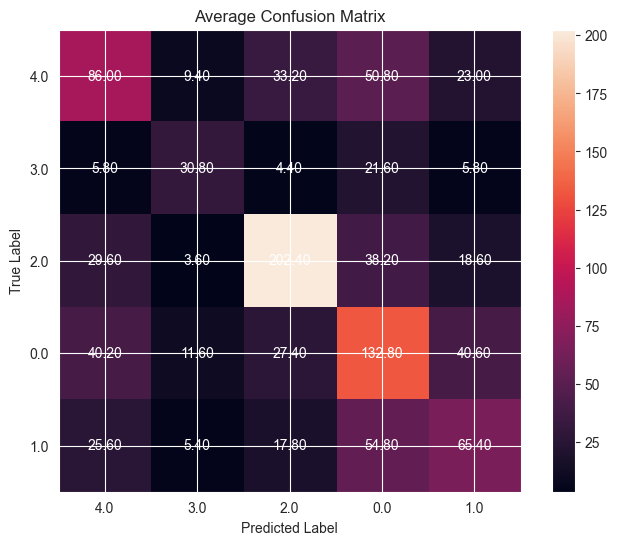

In [76]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

model = DecisionTreeClassifier(criterion='gini', max_depth=None)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
f1_scores = []
confusion_matrices = []

for train_index, test_index in skf.split(X_tfidf, df['emotion']):
    X_train_tfidf, X_test_tfidf = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = df['emotion'].iloc[train_index], df['emotion'].iloc[test_index]

    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion_matrix_values = confusion_matrix(y_test, y_pred)

    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    confusion_matrices.append(confusion_matrix_values)

print(f'Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}')
print(f'Average F1-score: {sum(f1_scores) / len(f1_scores):.2f}')

# Calculate the average confusion matrix
average_confusion_matrix = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(average_confusion_matrix)
plt.title('Average Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(df['emotion'].unique())), df['emotion'].unique())
plt.yticks(np.arange(len(df['emotion'].unique())), df['emotion'].unique())

for i in range(len(df['emotion'].unique())):
    for j in range(len(df['emotion'].unique())):
        plt.text(j, i, f"{average_confusion_matrix[i][j]:.2f}", ha="center", va="center", color="white")

plt.show()

In [77]:
param_grids = {
    'Random Forest': {'n_estimators': [50, 100, 150], 'max_depth': [5, 10, 15, None]},
}

In [78]:
for model_name, model_class in [
    ('Random Forest', RandomForestClassifier),
]:
    print(f'Optimizing {model_name} model...')
    model = model_class()
    grid_search = GridSearchCV(model, param_grid=param_grids[model_name], cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=['accuracy', 'f1_weighted'], refit='accuracy')
    grid_search.fit(X_tfidf, df['emotion'])

    #print(f'{model_name} - Best Accuracy: {grid_search.best_score_["accuracy"]:.2f}')
    #print(f'{model_name} - Best F1-score: {grid_search.best_score_["f1_weighted"]:.2f}')
    print(f'{model_name} - Best Hyperparameters: {grid_search.best_params_}')

Optimizing Random Forest model...
Random Forest - Best Hyperparameters: {'max_depth': None, 'n_estimators': 150}


Average Accuracy: 0.58
Average F1-score: 0.57


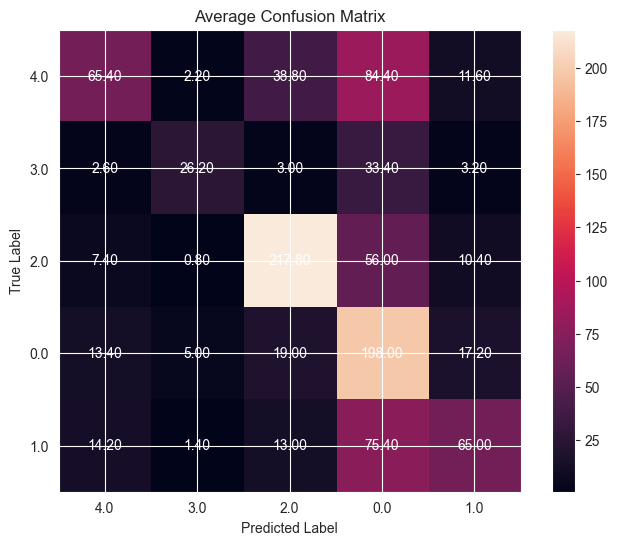

In [79]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

model = RandomForestClassifier(n_estimators=150, max_depth=None)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
f1_scores = []
confusion_matrices = []

for train_index, test_index in skf.split(X_tfidf, df['emotion']):
    X_train_tfidf, X_test_tfidf = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = df['emotion'].iloc[train_index], df['emotion'].iloc[test_index]

    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion_matrix_values = confusion_matrix(y_test, y_pred)

    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    confusion_matrices.append(confusion_matrix_values)

print(f'Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}')
print(f'Average F1-score: {sum(f1_scores) / len(f1_scores):.2f}')

# Calculate the average confusion matrix
average_confusion_matrix = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(average_confusion_matrix)
plt.title('Average Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(df['emotion'].unique())), df['emotion'].unique())
plt.yticks(np.arange(len(df['emotion'].unique())), df['emotion'].unique())

for i in range(len(df['emotion'].unique())):
    for j in range(len(df['emotion'].unique())):
        plt.text(j, i, f"{average_confusion_matrix[i][j]:.2f}", ha="center", va="center", color="white")

plt.show()

In [80]:
param_grids = {
    'AdaBoost': {'n_estimators': [50, 100, 150], 'learning_rate': [0.1, 0.5, 1.0]},
}

In [81]:
for model_name, model_class in [
    ('AdaBoost', AdaBoostClassifier),
]:
    print(f'Optimizing {model_name} model...')
    model = model_class()
    grid_search = GridSearchCV(model, param_grid=param_grids[model_name], cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=['accuracy', 'f1_weighted'], refit='accuracy')
    grid_search.fit(X_tfidf, df['emotion'])

    #print(f'{model_name} - Best Accuracy: {grid_search.best_score_["accuracy"]:.2f}')
    #print(f'{model_name} - Best F1-score: {grid_search.best_score_["f1_weighted"]:.2f}')
    print(f'{model_name} - Best Hyperparameters: {grid_search.best_params_}')

Optimizing AdaBoost model...


C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default)

AdaBoost - Best Hyperparameters: {'learning_rate': 0.5, 'n_estimators': 150}


C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default)

Average Accuracy: 0.48
Average F1-score: 0.46


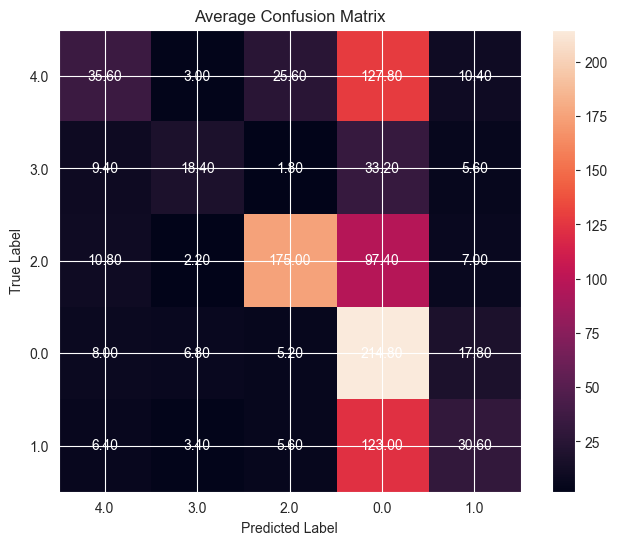

In [82]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

model = AdaBoostClassifier(learning_rate=0.5, n_estimators=150)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
f1_scores = []
confusion_matrices = []

for train_index, test_index in skf.split(X_tfidf, df['emotion']):
    X_train_tfidf, X_test_tfidf = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = df['emotion'].iloc[train_index], df['emotion'].iloc[test_index]

    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion_matrix_values = confusion_matrix(y_test, y_pred)

    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    confusion_matrices.append(confusion_matrix_values)

print(f'Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}')
print(f'Average F1-score: {sum(f1_scores) / len(f1_scores):.2f}')

# Calculate the average confusion matrix
average_confusion_matrix = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(average_confusion_matrix)
plt.title('Average Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(df['emotion'].unique())), df['emotion'].unique())
plt.yticks(np.arange(len(df['emotion'].unique())), df['emotion'].unique())

for i in range(len(df['emotion'].unique())):
    for j in range(len(df['emotion'].unique())):
        plt.text(j, i, f"{average_confusion_matrix[i][j]:.2f}", ha="center", va="center", color="white")

plt.show()

In [83]:
param_grids = {
    'Extra Tree': {'n_estimators': [50, 100, 150], 'criterion': ['gini', 'entropy']},
}

In [84]:
for model_name, model_class in [
    ('Extra Tree', ExtraTreesClassifier),
]:
    print(f'Optimizing {model_name} model...')
    model = model_class()
    grid_search = GridSearchCV(model, param_grid=param_grids[model_name], cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=['accuracy', 'f1_weighted'], refit='accuracy')
    grid_search.fit(X_tfidf, df['emotion'])

    #print(f'{model_name} - Best Accuracy: {grid_search.best_score_["accuracy"]:.2f}')
    #print(f'{model_name} - Best F1-score: {grid_search.best_score_["f1_weighted"]:.2f}')
    print(f'{model_name} - Best Hyperparameters: {grid_search.best_params_}')

Optimizing Extra Tree model...
Extra Tree - Best Hyperparameters: {'criterion': 'gini', 'n_estimators': 150}


Average Accuracy: 0.60
Average F1-score: 0.59


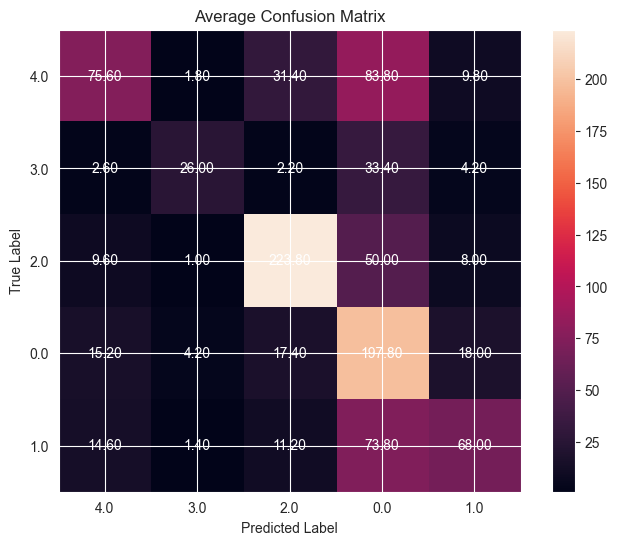

In [85]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

model = ExtraTreesClassifier(criterion='gini', n_estimators=150)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
f1_scores = []
confusion_matrices = []

for train_index, test_index in skf.split(X_tfidf, df['emotion']):
    X_train_tfidf, X_test_tfidf = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = df['emotion'].iloc[train_index], df['emotion'].iloc[test_index]

    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion_matrix_values = confusion_matrix(y_test, y_pred)

    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    confusion_matrices.append(confusion_matrix_values)

print(f'Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}')
print(f'Average F1-score: {sum(f1_scores) / len(f1_scores):.2f}')

# Calculate the average confusion matrix
average_confusion_matrix = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(average_confusion_matrix)
plt.title('Average Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(df['emotion'].unique())), df['emotion'].unique())
plt.yticks(np.arange(len(df['emotion'].unique())), df['emotion'].unique())

for i in range(len(df['emotion'].unique())):
    for j in range(len(df['emotion'].unique())):
        plt.text(j, i, f"{average_confusion_matrix[i][j]:.2f}", ha="center", va="center", color="white")

plt.show()

In [86]:
param_grids = {
    'LightGBM': {'num_leaves': [31, 63, 127], 'learning_rate': [0.1, 0.2, 0.3]}
}

In [87]:
for model_name, model_class in [
    ('LightGBM', LGBMClassifier)
]:
    print(f'Optimizing {model_name} model...')
    model = model_class()
    grid_search = GridSearchCV(model, param_grid=param_grids[model_name], cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=['accuracy', 'f1_weighted'], refit='accuracy')
    grid_search.fit(X_tfidf, df['emotion'])

    #print(f'{model_name} - Best Accuracy: {grid_search.best_score_["accuracy"]:.2f}')
    #print(f'{model_name} - Best F1-score: {grid_search.best_score_["f1_weighted"]:.2f}')
    print(f'{model_name} - Best Hyperparameters: {grid_search.best_params_}')

Optimizing LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8756
[LightGBM] [Info] Number of data points in the train set: 3939, number of used features: 332
[LightGBM] [Info] Start training from score -1.582883
[LightGBM] [Info] Start training from score -2.665554
[LightGBM] [Info] Start training from score -1.213923
[LightGBM] [Info] Start training from score -1.360977
[LightGBM] [Info] Start training from score -1.762489
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8827
[LightGBM] [Info] Number of data points in the train set: 3939, number of used features: 334
[LightGBM] [Info] Start training from score -1.582883
[Ligh

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8756
[LightGBM] [Info] Number of data points in the train set: 3939, number of used features: 332
[LightGBM] [Info] Start training from score -1.582883
[LightGBM] [Info] Start training from score -2.665554
[LightGBM] [Info] Start training from score -1.213923
[LightGBM] [Info] Start training from score -1.360977
[LightGBM] [Info] Start training from score -1.762489
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8827
[LightGBM] [Info] Number of data points in the train set: 3939, number of used features: 334
[LightGBM] [Info] Start 

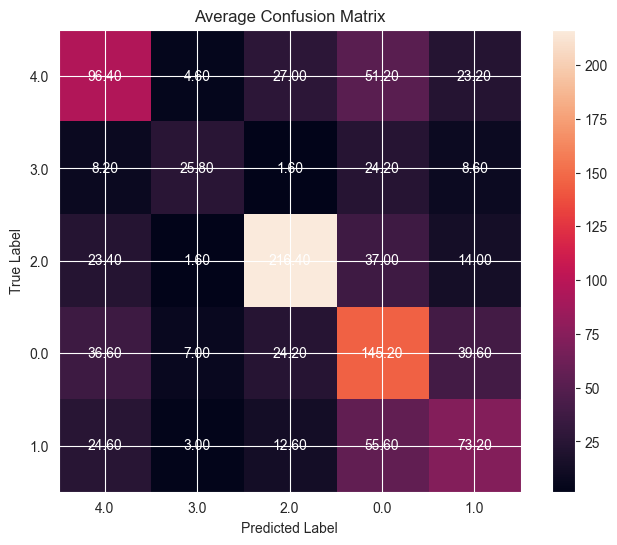

In [88]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

model = LGBMClassifier(num_leaves=63, learning_rate=0.1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
f1_scores = []
confusion_matrices = []

for train_index, test_index in skf.split(X_tfidf, df['emotion']):
    X_train_tfidf, X_test_tfidf = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = df['emotion'].iloc[train_index], df['emotion'].iloc[test_index]

    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion_matrix_values = confusion_matrix(y_test, y_pred)

    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    confusion_matrices.append(confusion_matrix_values)

print(f'Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}')
print(f'Average F1-score: {sum(f1_scores) / len(f1_scores):.2f}')

# Calculate the average confusion matrix
average_confusion_matrix = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(average_confusion_matrix)
plt.title('Average Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(df['emotion'].unique())), df['emotion'].unique())
plt.yticks(np.arange(len(df['emotion'].unique())), df['emotion'].unique())

for i in range(len(df['emotion'].unique())):
    for j in range(len(df['emotion'].unique())):
        plt.text(j, i, f"{average_confusion_matrix[i][j]:.2f}", ha="center", va="center", color="white")

plt.show()

In [89]:
param_grids = {
    'XGBoost': {'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.2, 0.3]},
}

In [90]:
for model_name, model_class in [
    ('XGBoost', XGBClassifier),
]:
    print(f'Optimizing {model_name} model...')
    model = model_class()
    grid_search = GridSearchCV(model, param_grid=param_grids[model_name], cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=['accuracy', 'f1_weighted'], refit='accuracy')
    grid_search.fit(X_tfidf, df['emotion'])

    #print(f'{model_name} - Best Accuracy: {grid_search.best_score_["accuracy"]:.2f}')
    #print(f'{model_name} - Best F1-score: {grid_search.best_score_["f1_weighted"]:.2f}')
    print(f'{model_name} - Best Hyperparameters: {grid_search.best_params_}')

Optimizing XGBoost model...
XGBoost - Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': 3}


Average Accuracy: 0.59
Average F1-score: 0.59


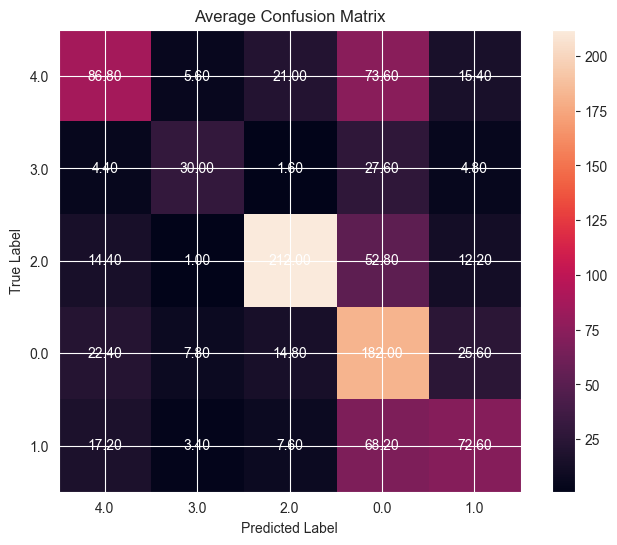

In [91]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

model = XGBClassifier(max_depth=3, learning_rate=0.3)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
f1_scores = []
confusion_matrices = []

for train_index, test_index in skf.split(X_tfidf, df['emotion']):
    X_train_tfidf, X_test_tfidf = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = df['emotion'].iloc[train_index], df['emotion'].iloc[test_index]

    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion_matrix_values = confusion_matrix(y_test, y_pred)

    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    confusion_matrices.append(confusion_matrix_values)

print(f'Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}')
print(f'Average F1-score: {sum(f1_scores) / len(f1_scores):.2f}')

# Calculate the average confusion matrix
average_confusion_matrix = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(average_confusion_matrix)
plt.title('Average Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(df['emotion'].unique())), df['emotion'].unique())
plt.yticks(np.arange(len(df['emotion'].unique())), df['emotion'].unique())

for i in range(len(df['emotion'].unique())):
    for j in range(len(df['emotion'].unique())):
        plt.text(j, i, f"{average_confusion_matrix[i][j]:.2f}", ha="center", va="center", color="white")

plt.show()

In [96]:
param_grids={
    'LogisticRegression': {'penalty': ['l1', 'l2']},
}

In [97]:
for model_name, model_class in [
    ('LogisticRegression', LogisticRegression),
]:
    print(f'Optimizing {model_name} model...')
    model = model_class()
    grid_search = GridSearchCV(model, param_grid=param_grids[model_name], cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=['accuracy', 'f1_weighted'], refit='accuracy')
    grid_search.fit(X_tfidf, df['emotion'])

    #print(f'{model_name} - Best Accuracy: {grid_search.best_score_["accuracy"]:.2f}')
    #print(f'{model_name} - Best F1-score: {grid_search.best_score_["f1_weighted"]:.2f}')
    print(f'{model_name} - Best Hyperparameters: {grid_search.best_params_}')

Optimizing LogisticRegression model...


C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Lenovo\AppD

LogisticRegression - Best Hyperparameters: {'penalty': 'l2'}


Average Accuracy: 0.63
Average F1-score: 0.62


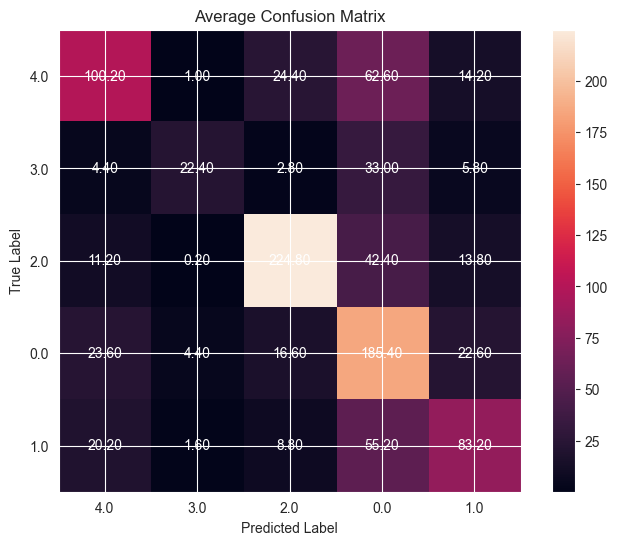

In [98]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

model = LogisticRegression(penalty='l2')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
f1_scores = []
confusion_matrices = []

for train_index, test_index in skf.split(X_tfidf, df['emotion']):
    X_train_tfidf, X_test_tfidf = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = df['emotion'].iloc[train_index], df['emotion'].iloc[test_index]

    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion_matrix_values = confusion_matrix(y_test, y_pred)

    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    confusion_matrices.append(confusion_matrix_values)

print(f'Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}')
print(f'Average F1-score: {sum(f1_scores) / len(f1_scores):.2f}')

# Calculate the average confusion matrix
average_confusion_matrix = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(average_confusion_matrix)
plt.title('Average Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(df['emotion'].unique())), df['emotion'].unique())
plt.yticks(np.arange(len(df['emotion'].unique())), df['emotion'].unique())

for i in range(len(df['emotion'].unique())):
    for j in range(len(df['emotion'].unique())):
        plt.text(j, i, f"{average_confusion_matrix[i][j]:.2f}", ha="center", va="center", color="white")

plt.show()

In [102]:
param_grids = {
    'KNN':{
        'n_neighbors': [3, 5, 7, 9, 11],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    }
}

In [103]:
from sklearn.neighbors import KNeighborsClassifier

for model_name, model_class in [
    ('KNN', KNeighborsClassifier),
]:
    print(f'Optimizing {model_name} model...')
    model = model_class()
    grid_search = GridSearchCV(model, param_grid=param_grids[model_name], cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=['accuracy', 'f1_weighted'], refit='accuracy')
    grid_search.fit(X_tfidf, df['emotion'])

    #print(f'{model_name} - Best Accuracy: {grid_search.best_score_["accuracy"]:.2f}')
    #print(f'{model_name} - Best F1-score: {grid_search.best_score_["f1_weighted"]:.2f}')
    print(f'{model_name} - Best Hyperparameters: {grid_search.best_params_}')

Optimizing KNN model...


C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
C:\Users\Lenovo\AppData\

KNN - Best Hyperparameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 11}


Average Accuracy: 0.54
Average F1-score: 0.52


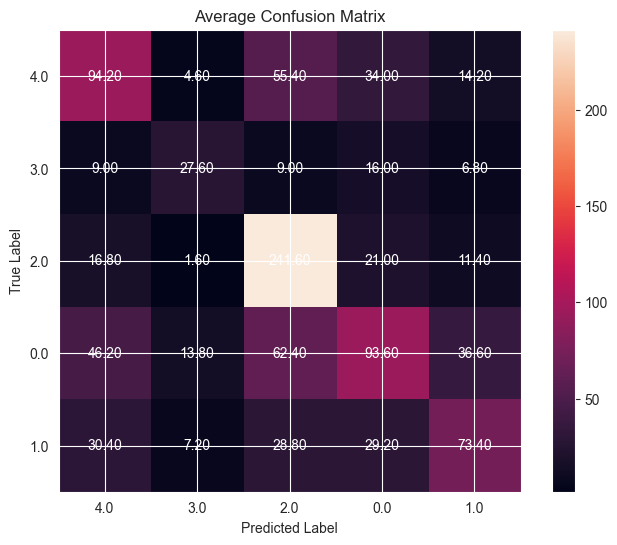

In [104]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

model = KNeighborsClassifier(metric='euclidean', n_neighbors=11, algorithm='auto')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
f1_scores = []
confusion_matrices = []

for train_index, test_index in skf.split(X_tfidf, df['emotion']):
    X_train_tfidf, X_test_tfidf = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = df['emotion'].iloc[train_index], df['emotion'].iloc[test_index]

    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion_matrix_values = confusion_matrix(y_test, y_pred)

    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    confusion_matrices.append(confusion_matrix_values)

print(f'Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}')
print(f'Average F1-score: {sum(f1_scores) / len(f1_scores):.2f}')

# Calculate the average confusion matrix
average_confusion_matrix = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(average_confusion_matrix)
plt.title('Average Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(df['emotion'].unique())), df['emotion'].unique())
plt.yticks(np.arange(len(df['emotion'].unique())), df['emotion'].unique())

for i in range(len(df['emotion'].unique())):
    for j in range(len(df['emotion'].unique())):
        plt.text(j, i, f"{average_confusion_matrix[i][j]:.2f}", ha="center", va="center", color="white")

plt.show()

In [109]:
param_grids = {
    'SVC':{
        'gamma': [0.001, 0.01, 0.1, 1],
        'kernel': ['rbf', 'poly'],
        'degree': [2, 3, 4],
    }
}

In [110]:
from sklearn.svm import SVC

for model_name, model_class in [
    ('SVC', SVC),
]:
    print(f'Optimizing {model_name} model...')
    model = model_class()
    grid_search = GridSearchCV(model, param_grid=param_grids[model_name], cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=['accuracy', 'f1_weighted'], refit='accuracy')
    grid_search.fit(X_tfidf, df['emotion'])

    #print(f'{model_name} - Best Accuracy: {grid_search.best_score_["accuracy"]:.2f}')
    #print(f'{model_name} - Best F1-score: {grid_search.best_score_["f1_weighted"]:.2f}')
    print(f'{model_name} - Best Hyperparameters: {grid_search.best_params_}')

Optimizing SVC model...
SVC - Best Hyperparameters: {'degree': 2, 'gamma': 1, 'kernel': 'rbf'}


Average Accuracy: 0.60
Average F1-score: 0.60


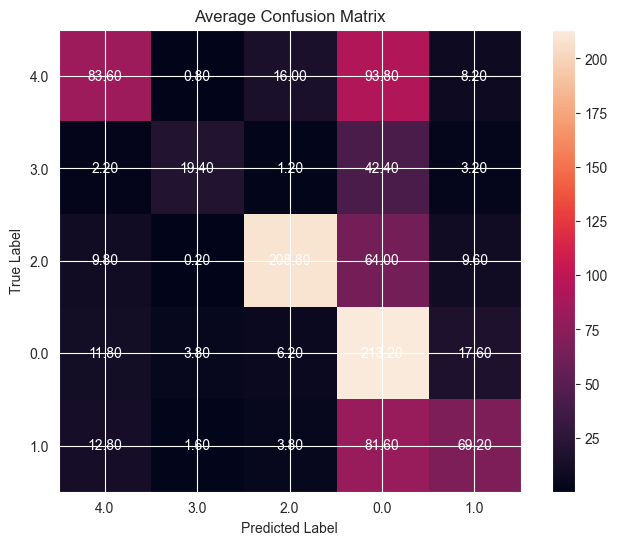

In [111]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

model = SVC(degree=2, gamma=1, kernel='rbf')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []
f1_scores = []
confusion_matrices = []

for train_index, test_index in skf.split(X_tfidf, df['emotion']):
    X_train_tfidf, X_test_tfidf = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = df['emotion'].iloc[train_index], df['emotion'].iloc[test_index]

    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    confusion_matrix_values = confusion_matrix(y_test, y_pred)

    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    confusion_matrices.append(confusion_matrix_values)

print(f'Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}')
print(f'Average F1-score: {sum(f1_scores) / len(f1_scores):.2f}')

# Calculate the average confusion matrix
average_confusion_matrix = np.mean(confusion_matrices, axis=0)

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(average_confusion_matrix)
plt.title('Average Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(df['emotion'].unique())), df['emotion'].unique())
plt.yticks(np.arange(len(df['emotion'].unique())), df['emotion'].unique())

for i in range(len(df['emotion'].unique())):
    for j in range(len(df['emotion'].unique())):
        plt.text(j, i, f"{average_confusion_matrix[i][j]:.2f}", ha="center", va="center", color="white")

plt.show()